# Visualisations

The aim of this notebook is to create some code that can be used throughout the project to import the data into Julia, and to visualise some of the data to get a better understanding of it.

In [2]:
using NPZ
using EzXML
using StatsPlots

## Importing - LFP

In [3]:
# Get the XML metadata file

lfp_path = "Exp 2/R7/2022-05-11_17-39-17/Record Node 101/"
files_xml = root(readxml("../data/$(lfp_path)Continuous_Data.openephys"))
recording = firstelement(firstelement(files_xml))

# Format XML data into Dict
files = Dict("processor" => recording["id"], "name" => [], "filename" => [], "position" => [], "bitVolts" => [])
for elem in eachelement(recording)
    push!(files["name"], elem["name"])
    filename = replace(elem["filename"], r"continuous$"=>"")
    push!(files["filename"], "$(filename)npz")
    push!(files["position"], elem["position"])
    push!(files["bitVolts"], elem["bitVolts"])
end
files

Dict{String, Any} with 5 entries:
  "name"      => Any["CH1", "CH2", "CH3", "CH4", "CH5", "CH6", "CH7", "CH8", "C…
  "processor" => "101"
  "filename"  => Any["100_1.npz", "100_2.npz", "100_3.npz", "100_4.npz", "100_5…
  "position"  => Any["1024", "1024", "1024", "1024", "1024", "1024", "1024", "1…
  "bitVolts"  => Any["0.19499999284744262695", "0.19499999284744262695", "0.194…

In [4]:
# Indexing lfp_data[channel, datapoint]

# Add data from each channel into a single matrix
n_datapoints = length(npzread("../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["data"])["data"][1:end-1024])
n_channels = length(files["filename"])
lfp_data = Array{Float32}(undef, n_channels, n_datapoints)
for i in 1:n_channels
    data = npzread("../data/formatted-lfp/$(lfp_path)$(files["filename"][i])", ["data"])["data"][1:end-1024] .* parse(Float64, files["bitVolts"][i])
    lfp_data[i, :] = data
end

In [5]:
# Add timestamps into vector 
# Timestamps are identical for each channel so this only needs to be done once
lfp_timestamps = npzread("../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["timestamps"])["timestamps"]
n_timestamps = length(lfp_timestamps)

lfp_timestamps_extended = [lfp_timestamps[i-1] + lfp_timestamps[i] * j / 1024 for i in 2:n_timestamps for j in 1:1024]

@assert length(lfp_timestamps_extended) == n_datapoints
lfp_timestamps_extended ./ 1000

1601536-element Vector{Float64}:
   25.8261953125
   25.852390625
   25.8785859375
   25.90478125
   25.9309765625
   25.957171875
   25.9833671875
   26.0095625
   26.0357578125
   26.061953125
    ⋮
 3240.9344375
 3242.5236328125
 3244.112828125
 3245.7020234375
 3247.29121875
 3248.8804140625
 3250.469609375
 3252.0588046875
 3253.648

## Visualisations - LFP

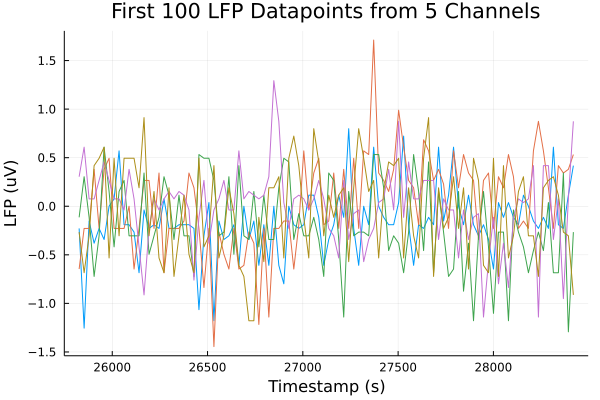

In [6]:
plot(lfp_timestamps_extended[1:100], lfp_data[1,1:100], legend=false)
for i in 2:5
    plot!(lfp_timestamps_extended[1:100], lfp_data[i,1:100], legend=false)
end
title!("First 100 LFP Datapoints from 5 Channels")
xlabel!("Timestamp (s)")
ylabel!("LFP (uV)")

## Importing - Events

In [7]:
events_data = npzread("../data/formatted-lfp/$(lfp_path)all_channels.npz")

Dict{String, Vector{Float64}} with 7 entries:
  "eventId"         => [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0  …  0.…
  "channel"         => [7.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0  …  4.…
  "nodeId"          => [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0,…
  "eventType"       => [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0  …  3.…
  "timestamps"      => [25998.0, 27999.0, 28499.0, 38504.0, 39004.0, 49009.0, 4…
  "sampleNumber"    => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  "recordingNumber" => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…

In [13]:
scatter(events_data["timestamps"][1:3], zeros(length(events_data["timestamps"][1:3])), label="Event")
for i in 1:3
    plot!(lfp_timestamps_extended[1:100], lfp_data[i,1:100], label="Channel $(i)")
end
title!("First 100 LFP Datapoints from 3 Channels")
xlabel!("Timestamp (s)")
ylabel!("LFP (uV)")

## Importing - O2 

In [18]:
# Indexing o2_data[datapoint, time/o2]

o2_path = "Exp 1/R4/"
filename = "o2data R4.txt"
o2_data = []
open("../data/$(o2_path)$(filename)") do file
    for line in eachline(file)
        if isdigit(line[1])
            data_element = split(line, "\t")
            data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2])]
            push!(o2_data, data_element)
        end
    end
end
o2_data = reduce(vcat,transpose.(o2_data))

1508564×2 Matrix{Float32}:
    0.0    -114.384
    0.001  -114.384
    0.002  -114.384
    0.003  -114.384
    0.004  -114.384
    0.005  -114.384
    0.006  -114.384
    0.007  -114.384
    0.008  -114.384
    0.009  -114.384
    ⋮      
 1508.56    -91.092
 1508.56    -91.092
 1508.56    -91.092
 1508.56    -91.092
 1508.56    -91.092
 1508.56    -91.092
 1508.56    -91.092
 1508.56    -91.092
 1508.56    -91.092

## Visualisations - O2

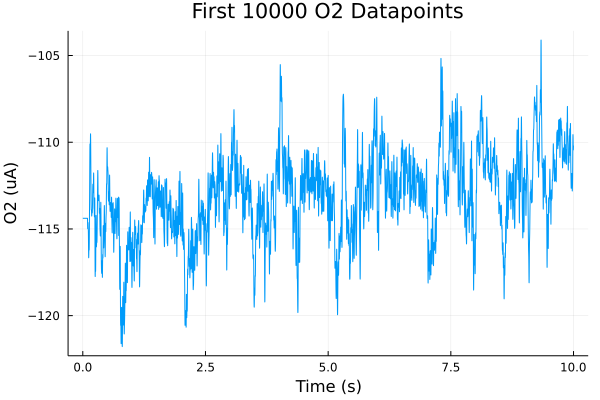

In [19]:
plot(o2_data[1:10000, 1], o2_data[1:10000, 2], legend=false)
title!("First 10000 O2 Datapoints")
xlabel!("Time (s)")
ylabel!("O2 (uA)")